[[0.8022461  0.7998047  0.8022461  ... 1.1728516  1.1464844  1.1660156 ]
 [0.79785156 0.81591797 0.81152344 ... 1.1630859  1.1630859  1.1240234 ]
 [0.8027344  0.80322266 0.80810547 ... 1.1679688  1.1679688  1.1503906 ]
 ...
 [1.2568359  1.2685547  1.2695312  ... 1.2714844  1.2646484  1.2724609 ]
 [1.2617188  1.2880859  1.2666016  ... 1.265625   1.2617188  1.265625  ]
 [1.2304688  1.2509766  1.2646484  ... 1.2626953  1.2695312  1.2636719 ]]


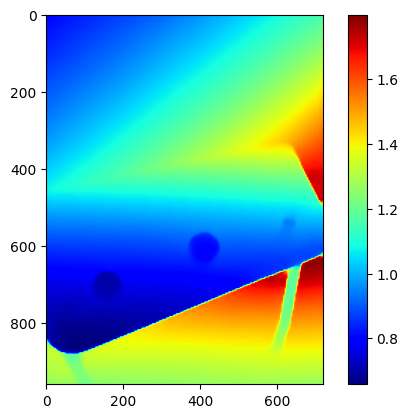

In [20]:
import numpy as np
import liblzfse
import matplotlib.pyplot as plt
import sys
import cv2
path = './images/525.depth'
def load_depth(filepath):
    with open(filepath, 'rb') as depth_fh:
        raw_bytes = depth_fh.read()
        decompressed_bytes = liblzfse.decompress(raw_bytes)
        depth_img = np.frombuffer(decompressed_bytes, dtype=np.float32)

    # depth_img = depth_img.reshape((640, 480))  # For a FaceID camera 3D Video
    depth_img = depth_img.reshape((256, 192))  # For a LiDAR 3D Video

    return depth_img


if __name__ == '__main__':
    depth_filepath = path
    depth_img = load_depth(depth_filepath)
    print(depth_img)
    depth_img = cv2.resize(depth_img, (720, 960))

    plt.imshow(depth_img, 'jet')
    plt.colorbar()
    plt.show()


In [13]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
from matplotlib import pyplot as plt 

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

url = "./images/525.jpg"
image = Image.open(url)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

/home/hyuk/anaconda3/envs/schange/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
a = np.array(depth)
a

array([[163, 163, 162, ...,  74,  65,  53],
       [158, 160, 161, ...,  72,  69,  65],
       [156, 159, 161, ...,  70,  72,  75],
       ...,
       [100,  99,  98, ...,  89,  89,  88],
       [ 93,  96,  98, ...,  88,  86,  85],
       [ 84,  92,  99, ...,  86,  83,  81]], dtype=uint8)

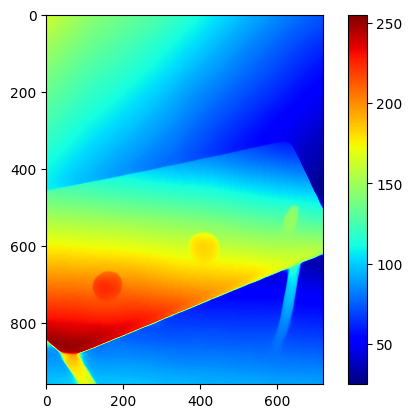

In [32]:
plt.imshow(a , cmap='jet')
plt.colorbar()
plt.show()

In [5]:
import numpy as np
path = './images/525.depth'
with open(path, 'rb') as depth_fh:
    raw_bytes = depth_fh.read()
    decompressed_bytes = liblzfse.decompress(raw_bytes)
    depth_img = np.frombuffer(decompressed_bytes, dtype=np.float32)
depth_img      

array([0.8022461, 0.7998047, 0.8022461, ..., 1.2626953, 1.2695312,
       1.2636719], dtype=float32)

In [15]:
recon = liblzfse.compress(a)

In [17]:
decompressed_bytes = liblzfse.decompress(recon)
depth_img = np.frombuffer(decompressed_bytes, dtype=np.float32)
depth_img

array([-1.1020861e-18, -4.4082382e-18, -1.0952833e-18, ...,
        1.5365222e+16,  1.5365222e+16,  5.6730419e+10], dtype=float32)

In [3]:
import numpy as np
np.array(raw_img).shape

NameError: name 'raw_img' is not defined

In [5]:
np.shape(raw_img)

(960, 720, 3)

In [13]:
import cv2
import torch
import numpy as np

from depth_anything_v2.dpt import DepthAnythingV2
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vitl' # or 'vits', 'vitb'
dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 20 # 20 for indoor model, 80 for outdoor model

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
model.to(DEVICE).eval()

raw_img = cv2.imread('./images/525.jpg')
# raw_img[:, :, 0], raw_img[:, :, 1], raw_img[:, :, 2] = raw_img[:, :, 2], raw_img[:, :, 1], raw_img[:, :, 0]
depth = model.infer_image(raw_img, np.shape(raw_img)[:2]) # HxW depth map in meters in numpy

/tmp/ipykernel_202256/2105966686.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{enco

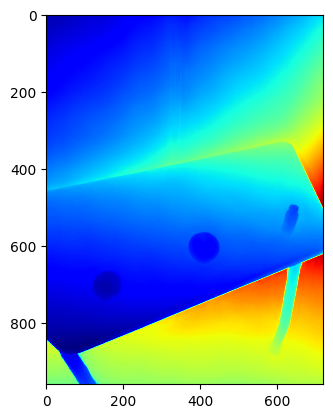

In [14]:
from matplotlib import pyplot as plt
plt.imshow(depth, cmap='jet')

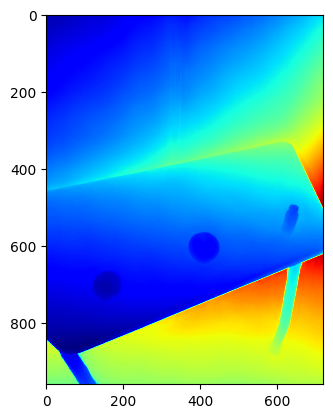

In [21]:
from matplotlib import pyplot as plt
plt.imshow(depth, cmap='jet')

In [37]:
diff1 = depth-depth_img

In [40]:

m_depth = (depth - np.mean(depth))/np.std(depth)
img_norm1 = cv2.normalize(m_depth, None, np.min(depth_img), np.max(depth_img), cv2.NORM_MINMAX)
diff2 = img_norm1-depth_img

img_norm2 = cv2.normalize(depth, None, np.min(depth_img), np.max(depth_img), cv2.NORM_MINMAX)
diff3 = img_norm2-depth_img


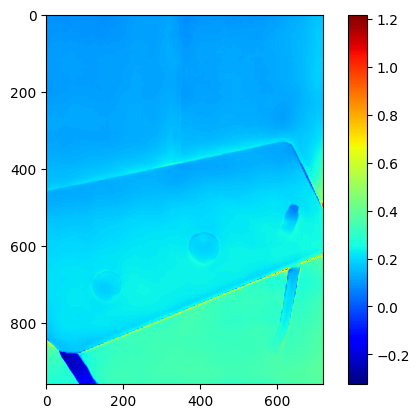

135970.44

In [43]:
plt.imshow(diff1, cmap='jet')
plt.colorbar()
plt.show()
np.sum(abs(diff1))

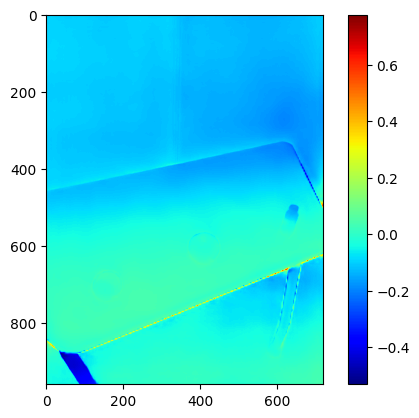

55777.76

In [47]:
plt.imshow(diff2, cmap='jet')
plt.colorbar()
plt.show()
np.sum(abs(diff2))

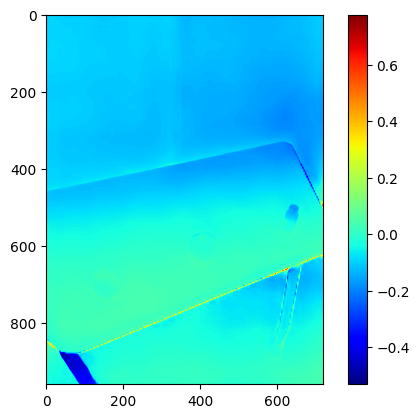

55777.79

In [45]:
plt.imshow(diff3, cmap='jet')
plt.colorbar()
plt.show()
np.sum(abs(diff3))
